In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import pandas as pd
import itertools
import matplotlib
import os
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio import SeqUtils
import matplotlib.cm as cm
from ete3 import NCBITaxa
import re
import fileinput

The idea of the scritp is to use the output of xxxxxxF.gcoords from the v8_1_ph_p_on_p_nucmer.sh script. These will be simplified by calculating the cumsum for each pwh contig hit. The p_woh will be renamed to generate a name association with its best pwh hit. The new name will be pwh_pwoh.

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }


In [3]:
#THIS script still needs to be fixed for the cases where mummer alignment ends overlap

In [7]:
#define working directory
file_path = "/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v8_1/v8_1_unzip/QC_unpolished/nucmer/nucmer_pwoh_on_pwoh"
pwoh_fn = "v8_1_ph_tr_ctg_pwoh_ctg.fa"
pwoh_rn_fn = "" #for the rename
h_above_200_fn = ''
p_above_200_fn =''
h_fn = ''

In [8]:
#write a bash script that maps all pwoh on pwoh expect itself with h using the '-r' option
pwoh_fn = 'v8_1_ph_tr_ctg_pwoh_ctg.fa' #file that contains all pwoh

In [9]:
os.chdir(file_path)

In [13]:
r_bs="v8_1_pwoh_on_pwoh_rnucmer.sh"
g_bs="v8_1_pwoh_on_pwoh_gnucmer.sh"
outfr = open(r_bs,'w')
outfg = open(g_bs, 'w')
outfr.write('#!/bin/bash\n')
outfg.write('#!/bin/bash\n')
for pseq_record in SeqIO.parse(pwoh_fn, 'fasta'):
    non_self_contigs = []
    pwoh_contig = pseq_record
    suffix = pwoh_fn[:-3]+pseq_record.id.split("|")[0]+"_non_self"
    p_file = pwoh_fn[0:-3]+"_"+pseq_record.id.split("|")[0]+'.fa'
    SeqIO.write(pwoh_contig, p_file, 'fasta')
    for non_self_seq in SeqIO.parse(pwoh_fn, 'fasta'):
        if non_self_seq.id.split("|")[0] != pwoh_contig.id.split("|")[0]:
            non_self_contigs.append(non_self_seq)
    non_self_fn = pwoh_fn[:-3]+"_"+pseq_record.id.split("|")[0]+'_non_self.fa'
    #safe non_self contigs
    if non_self_contigs != []:
        SeqIO.write(non_self_contigs, non_self_fn, 'fasta')
        outfr.write('nucmer '+p_file+' '+non_self_fn+" > "+'out.delta\n')
        outfr.write('delta-filter -r '+'out.delta'+" > "+suffix+"_rfiltered.delta\n")
        outfr.write('show-coords -T '+suffix+"_rfiltered.delta > "+suffix+".rcoords\n")
        outfr.write('mummerplot -p '+suffix+'_rfiltered --postscript '+suffix+"_rfiltered.delta\n")
        outfr.write('mummerplot -c -p '+suffix+'_rfiltered_cov --postscript '+suffix+"_rfiltered.delta\n")
        #for g_file bash script
        outfg.write('nucmer '+p_file+' '+non_self_fn+" > "+'out.delta\n')
        outfg.write('delta-filter -g '+'out.delta'+" > "+suffix+"_gfiltered.delta\n")
        outfg.write('show-coords -T '+suffix+"_gfiltered.delta > "+suffix+".gcoords\n")
        outfg.write('mummerplot -p '+suffix+'_gfiltered --postscript '+suffix+"_gfiltered.delta\n")
        outfg.write('mummerplot -c -p  '+suffix+'_gfiltered_cov --postscript '+suffix+"_gfiltered.delta\n")
outfr.close()
outfg.close()

In [10]:
#get all the .gcoords files
file_handler = os.walk(file_path, topdown=False)
gcoords_files = [x for x in list(file_handler)[-1][2] if x[-7:]== 'gcoords']
pwoh_rn_dic ={} #dic for renaming pwoh
#hit_summary_df = pd.DataFrame(columns=['pwoh', 'best hit p', 'pwoh len', '%len hit', '%ID']) #summary dataframe that indicates best hit for each pwoh, 

In [11]:
#make dataframe of initial query file pwoh_fn
handle_1 = open(pwoh_fn)
contigs = SeqIO.parse(handle_1, 'fasta')
contig_length = []
contig_id =[]
for x in contigs:
    contig_id.append(x.id)
    contig_length.append(len(x.seq))
s1 = pd.Series(contig_id, name='ID')
s2 = pd.Series(contig_length, name='Length')
pwoh_df = pd.concat([s1, s2], axis=1)
handle_1.close()

In [12]:
#here pull in each gcoords file and define the longest p_wh hit on each p_woh. Save summary results in new data frame
#and generate renaming dictonary
#rename outfile for hit summary df
name_list = []
len_list=[]
rel_len_list=[]
pc_ID_list=[]
best_hit_list=[]
for x in gcoords_files:
    best_hit = ''
    mummer_df_tmp = ''
    mummer_df_tmp = pd.read_csv(file_path+'/'+x, sep='\t', header=None,skiprows=4 )
    header_mum = ["S1","E1","S2", "E2","LEN 1", "LEN 2", "% IDY", "ID-p", "ID-h"]
    rename = dict(zip(mummer_df_tmp.columns, header_mum))
    mummer_df_tmp.rename(columns=rename,inplace=True)
    #till here it reads in the gcoords_files as a dataframe
    best_hit = mummer_df_tmp.groupby('ID-p')['LEN 1'].sum().sort_values().index[-1] #this gets the p_wh that has the highest coverage in length
    best_hit_list.append(best_hit)
    best_df  = mummer_df_tmp[mummer_df_tmp['ID-p'] == best_hit]
    best_df['rel %'] = best_df['LEN 2']*best_df['% IDY']
    pc_ID_list.append(best_df['rel %'].sum()/best_df['LEN 2'].sum())
    #up to here the %_ID is calcuated for the best hit
    name_list.append(x[:-8])
    len_list.append(pwoh_df.loc[pwoh_df['ID']==x[:-8],'Length'].sum())
    rel_len_list.append(best_df['LEN 2'].sum()/pwoh_df.loc[pwoh_df['ID']==x[:-8],'Length'].sum()*100)
    pwoh_rn_dic[x[:-8]]=best_hit+'_'+x[:-8]
hit_summary_df = pd.concat([pd.Series(name_list), pd.Series(best_hit_list), pd.Series(len_list), pd.Series(rel_len_list), pd.Series(pc_ID_list)],axis=1, keys=['p_woh', 'best hit p_wh', 'p_woh len', '%len hit', '%ID'])
hit_summary_df['%len hit'] = hit_summary_df['%len hit'].round(2)
hit_summary_df['%ID'] = hit_summary_df['%ID'].round(2)
hit_summary_df.to_csv(file_path+'/v8_1_p_woh_on_p_wh_best_hit_summary_gcoords.csv', index=False)
#pwoh_rn_dic

/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
#rename p_woh to hs
p_woh_list =[]
for p_woh in SeqIO.parse(pwoh_fn, 'fasta'):
    tmp_id =''
    tmp_seq=''
    tmp_id = pwoh_rn_dic[p_woh.id]
    tmp_seq = p_woh.seq
    p_woh_list.append(SeqRecord(tmp_seq, id=tmp_id, description=''))
SeqIO.write(p_woh_list, pwoh_rn_fn, 'fasta')

113

In [30]:
rn_fn = [pwh_contigs_fn, pwoh_rn_fn, p_above_200_fn, h_fn  , h_above_200_fn]

In [32]:
with open('v8_1_ph_tr_ctg_rn_gcoords_all.fa', 'w') as fout, fileinput.input(rn_fn) as fin:
    for line in fin:
        fout.write(line)

In [ ]:
SeqRecord

now look at the average mapping of h on p for each h

In [8]:
h_on_p_fp = "/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v8_1/v8_1_unzip/QC_unpolished/nucmer/nucmer_h_on_pwh"
p_and_h_fp = '/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v8_1/v8_1_unzip/'
p_and_h_fn = "v8_1_ph_tr_ctg.fa"


In [9]:
#make dataframe of initial h contigs
handle_2 = open(p_and_h_fp+p_and_h_fn)
h_contigs = SeqIO.parse(handle_2, 'fasta')
h_contig_length = []
h_contig_id =[]
for y in h_contigs:
    if '_' in list(y.id):
        h_contig_id.append(y.id)
        h_contig_length.append(len(y.seq))
s3 = pd.Series(h_contig_id, name='ID')
s4 = pd.Series(h_contig_length, name='Length')
h_df = pd.concat([s3, s4], axis=1)
handle_2.close()

In [10]:
os.chdir(h_on_p_fp)

In [11]:
!pwd

/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v8_1/v8_1_unzip/QC_unpolished/nucmer/nucmer_h_on_pwh


In [12]:
fh_2 = os.walk(h_on_p_fp, topdown=False)
h_gcoords_files = [x for x in list(fh_2)[-1][2] if x[-7:]== 'gcoords']

In [13]:
len(h_gcoords_files)

89

In [14]:
#make a summary data frame that provides the % of mapping hits and % of ID for each h on p_wh mapping
h_len =[]
h_id = []
p_id = []
h_pc_len = []
h_pc_id =[]
# up to here initiate the list that will make the dataframe at the end
for h in h_gcoords_files:
    #read in each mummer gcoords file and make df out of it
    mummer_df_tmp = pd.read_csv(h_on_p_fp+'/'+h, sep='\t', header=None,skiprows=4 )
    header_mum = ["S1","E1","S2", "E2","LEN 1", "LEN 2", "% IDY", "ID-p", "ID-h"]
    rename = dict(zip(mummer_df_tmp.columns, header_mum))
    mummer_df_tmp.rename(columns=rename,inplace=True)
    h_ctg_list = list(set(mummer_df_tmp["ID-h"].tolist()))
    #get all h_ctgs for each p_ctg
    for h_sub in h_ctg_list:
        #calculate pc_id and pc_len for each hapolitg aligning to the primary contig
        sub_df = ''
        pc_length = ''
        sub_pc_id =''
        h_id.append(h_sub) #add the id to the list
        sub_df = mummer_df_tmp[mummer_df_tmp['ID-h'] == h_sub] #get the df concerning only the current h_ctg
        sub_df
        p_id.append(sub_df['ID-p'].tolist()[0])
        h_len.append(h_df[h_df['ID'] == h_sub]['Length'].sum())
        h_sub_length = sub_df['LEN 2'].sum() #get the aligned length
        pc_length = h_sub_length/h_df[h_df['ID'] == h_sub]['Length'].sum()*100 #calculate the pc_length
        h_pc_len.append(pc_length)
        sub_df["rel %"] = sub_df['LEN 2']*sub_df['% IDY']
        sub_pc_id = sub_df["rel %"].sum()/h_sub_length #calculate the relative identity
        h_pc_id.append(sub_pc_id)
h_on_p_summary_df = pd.concat([pd.Series(h_id), pd.Series(p_id), pd.Series(h_len), pd.Series(h_pc_len), pd.Series(h_pc_id)],axis=1, keys=['h-ID', 'p-ID', 'h len', '%len h_ctg hit', '%ID h'])
h_on_p_summary_df['%len h_ctg hit'] = h_on_p_summary_df['%len h_ctg hit'].round(2)
h_on_p_summary_df['%ID h'] = h_on_p_summary_df['%ID h'].round(2)
h_on_p_summary_df.to_csv(h_on_p_fp+'/v8_1_h_on_pwh_summary.csv', index=False)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#all seems to be alright but 000082F_001 didn't align to its primary contig with the given options of cat 
nucmer v8_1_ph_tr_ctg_000082F.fa v8_1_ph_tr_ctg_000082F_a_ctg.fa > out.delta
delta-filter -g out.delta > v8_1_ph_000082Fpap_gfiltered.delta
show-coords -T v8_1_ph_000082Fpap_gfiltered.delta > v8_1_ph_000082Fpap.gcoords
##check what is going on there

set(h_df['ID'].tolist())-set(h_on_p_summary_df['h-ID'].tolist())

h_df[h_df['ID']=='000082F_001']['Length']

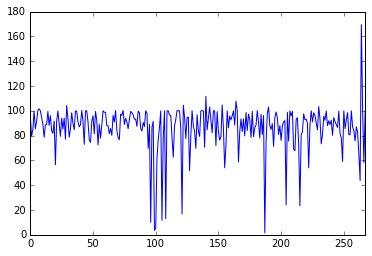

In [16]:
h_on_p_summary_df['%len h_ctg hit'].plot()

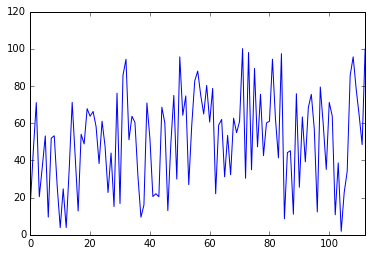

In [20]:
hit_summary_df['%len hit'].plot()

(0, 200)

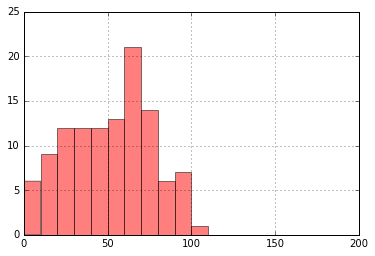

In [30]:
hit_summary_df['%len hit'].hist(bins=20, range=(0,200), color='r', alpha=0.5)
plt.xlim(0,200)

(0, 200)

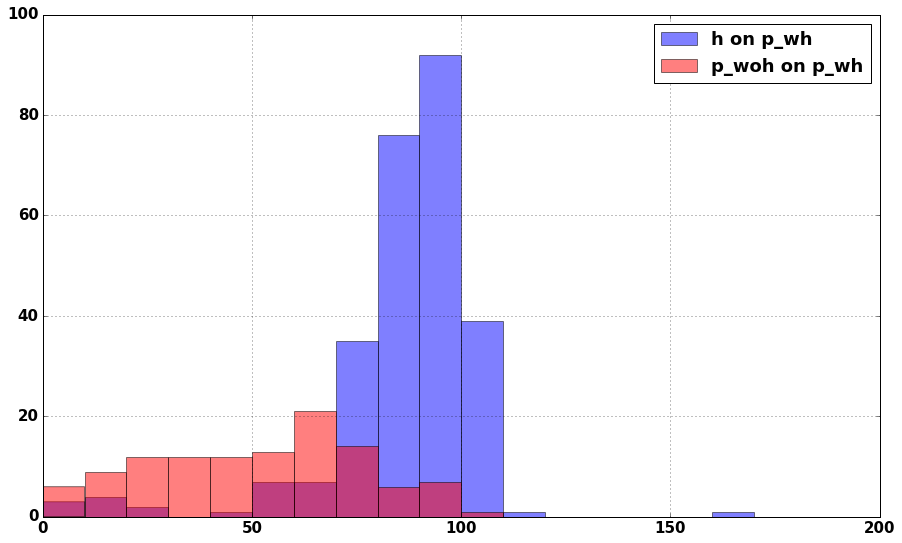

In [54]:
plt.figure(figsize=(15,9))
h_on_p_summary_df['%len h_ctg hit'].hist(bins=20, range=(0,200), alpha=0.5, label='h on p_wh')
hit_summary_df['%len hit'].hist(bins=20, range=(0,200), color='r', alpha=0.5, label='p_woh on p_wh')
plt.legend(loc=0)
plt.xlim(0,200)

(0, 100)

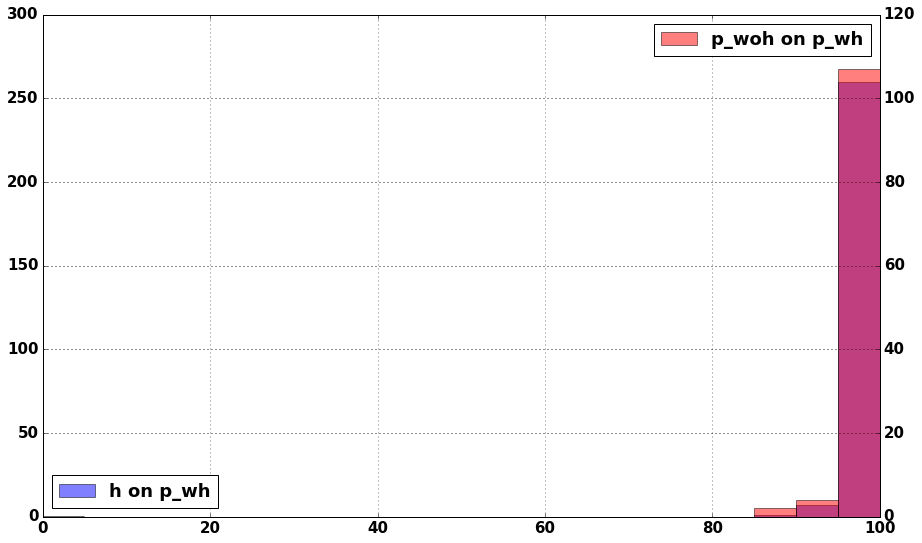

In [60]:
fig, ax1 = plt.subplots(figsize=(15,9))
h_on_p_summary_df['%ID h'].hist(bins=20, range=(0,100), alpha=0.5, label='h on p_wh' )
plt.legend(loc=3)
ax2 = ax1.twinx()
hit_summary_df['%ID'].hist(bins=20, range=(0,100), color='r', alpha=0.5, label='p_woh on p_wh')
plt.legend(loc=0)
plt.xlim(0,100)

In [63]:
h_on_p_summary_df[h_on_p_summary_df['%len h_ctg hit'] < 50]

,h-ID,p-ID,h len,%len h_ctg hit,%ID h
96,000016F_010,000016F,17363,10.01,90.33
99,000016F_006,000016F,13145,3.61,94.95
100,000016F_001,000016F,13656,5.29,91.53
105,000017F_004,000017F,9700,11.66,90.01
108,000017F_007,000017F,8756,12.94,95.30
121,000018F_002,000018F,9677,16.84,88.29
187,000038F_003,000038F,7495,1.60,97.50
204,000049F_002,000049F,9177,24.10,92.80
215,000055F_001,000055F,48197,23.48,92.13
263,000170F_001,000170F,8799,43.78,99.92


In [36]:
h_on_p_summary_df.plot

TypeError: hexbin() missing 2 required positional arguments: 'x' and 'y'

In [61]:
h_on_p_summary_df.head()

,h-ID,p-ID,h len,%len h_ctg hit,%ID h
0,000000F_010,000000F,84607,95.81,98.66
1,000000F_005,000000F,333604,79.68,98.07
2,000000F_008,000000F,193067,84.60,99.22
3,000000F_018,000000F,17417,99.77,98.02
4,000000F_015,000000F,107956,85.48,99.28
